# Face Generation
In this project, generative adversarial networks will be used to generate new images of faces.
### Get the Data
Two data sets will be used in this project...
- [MNIST](http://yann.lecun.com/exdb/mnist/)
- [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 

The network will first be tested with using the MNIST data before moving on to the more complex images CelebA data set.

In [1]:
# Specify local data dir if using local files
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST 

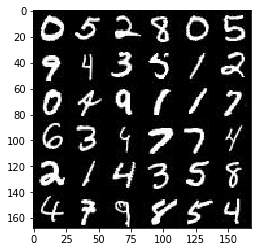

In [4]:
show_n_images = 36

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

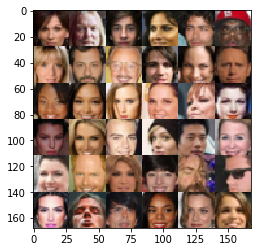

In [5]:
show_n_images = 36

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
The components necessary to build the GAN are implemented in the following functions.
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implementation the `model_inputs` function to create TF Placeholders for the Neural Network. Creates the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Returns the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real Inputs
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, 
                                  image_width, 
                                  image_height, 
                                  image_channels), 
                                 name="input_real") 
    
    # Z Inputs
    inputs_z = tf.placeholder(tf.float32, 
                              (None, z_dim), 
                              name='input_z')
    
    # Learning Rate
    learn_rate = tf.placeholder(tf.float32, 
                                name='learning_rate')

    return inputs_real, inputs_z, learn_rate


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implementation of the `discriminator` function to create a discriminator neural network that discriminates on `images`. The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # alpha value for leaky relu
        alpha = 0.01

        # Layer One
        # Input Layer in 28x28x3 = -> out = 14x14x64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        relux1 = tf.maximum(alpha*x1, x1)
        relu1 = tf.nn.dropout(relux1, 0.7)

        # Layer Two - output = 7x7x256
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relux2 = tf.maximum(alpha*bn2, bn2)
        relu2 = tf.nn.dropout(relux2, 0.7)


        # Layer Three - output = 4x4x256
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding = "same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relux3 = tf.maximum(alpha*bn3, bn3)
        relu3 = tf.nn.dropout(relux3, 0.7)

        # Squish the relu 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implementation of `generator` function to generate an image using `z`. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):
        # alpha for leaky relu
        alpha = 0.01
        
        # Here is Layer One, Fully connected, in shape = 100
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape ->  out = 7x7x512
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        
        # (Layer 2), out_shape = 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        
        # (Layer 3), out_shape = 28x28x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same", kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.7)
        
        # To Do: Try with 4 layers !?!?!?
        
        #(Output Layer), out_shape = 28x28x5
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        out = tf.tanh(logits)
        
    return out


tests.test_generator(generator, tf)

Tests Passed


### Loss
Implementation of the `model_loss` function to build the GANs for training and to calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The Models
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    # The Real D Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real, 
                     labels = 0.9*tf.ones_like(d_model_real)))
    
    # Fake D Loss
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, 
                     labels = 0.9*tf.zeros_like(d_model_fake)))
    
    # G Loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
                     labels = 0.9*tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implementation of `model_opt` function to create the optimization operations for the GANs.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get Weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimizations using AdamOptimzer
    with tf. control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
        
    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
This function is used to show the current output of the generator during training

In [29]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [30]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                             real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

### Train
Implementation of `train`function to build and train the GANs. Shows output of the `generator` function periodically during training.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Stuff from class GAN -> TODO: use class def to simplify code here
    #saver = tf.train.Saver()
    _, img_w, img_h, img_chan = data_shape
    print_every = 10
    show_every = 100
    # Use with class def
    # sample_z = np.random_uniform(-1, 1, size=())
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], 
                                                   data_shape[2], 
                                                   data_shape[3], 
                                                   z_dim)
    
    d_loss, g_loss = model_loss(input_real,
                               input_z, 
                               len(data_image_mode))
    
    d_train_opt, g_train_opt = model_opt(d_loss,
                                        g_loss,
                                        learn_rate,
                                        beta1)
    
    steps = 0
    #losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for Gee
                x = batch_images * 2.0
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real : x, 
                                                       input_z : batch_z, 
                                                       learn_rate : learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z, 
                                                       input_real : x,
                                                       learn_rate : learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real : x,
                                                input_z : batch_z})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    #losses.append(train_loss_d, train_loss_g)
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 9, input_z, img_chan, data_image_mode)
                    #saver.save(sess, './checkpoints/generator.ckpt')
                    
                
                #return losses
                    
                

### MNIST
Testing GANs architecture on MNIST data.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Aiming to have the loss of the generator lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.5510
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 3.3521
Epoch 1/2... Discriminator Loss: 1.5847... Generator Loss: 2.7999
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.7655
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 1.8337
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.4384
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.9338


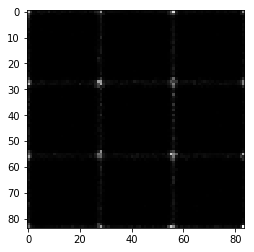

Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.4031
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 1.7134
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.2793
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 1.0774
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 1.4996
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 1.5147


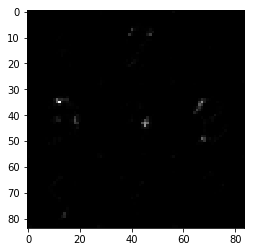

Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 2.3020
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.2261
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 1.4266
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.9374
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.8169
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.7872
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.1455


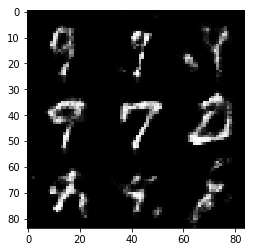

Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.4835
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.2653
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 1.8761
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 1.2144
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 1.0924
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 1.2899
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.5406
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 1.1213


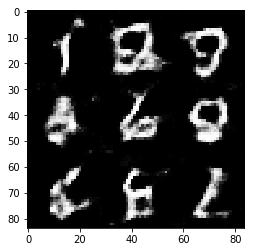

Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 1.3662
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 1.3663
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 1.7756
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 1.0114


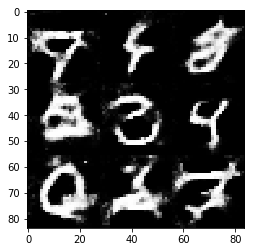

Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 1.1421
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.2452
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 1.2459
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 1.2364


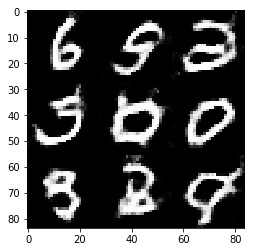

Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.4226
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 1.0657
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 1.4043
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 1.1281... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.0899


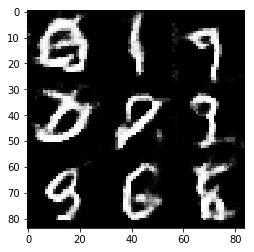

Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 1.0952
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 1.1074
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.9857
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.2355


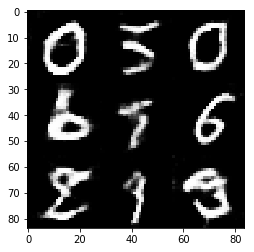

Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 1.3149
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 1.1825
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 1.2516
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 1.3527
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 1.2334


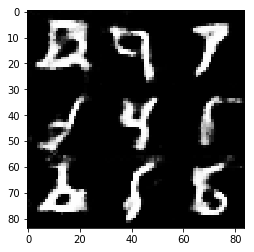

Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 1.2614
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.9096


In [32]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Runing the GANs on CelebA. (apx. run time per epoch = 20 min)

Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 2.5652
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.8703
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 3.2914
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 3.4590
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 2.5108
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.9916
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 2.9465
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.5560
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 3.3012


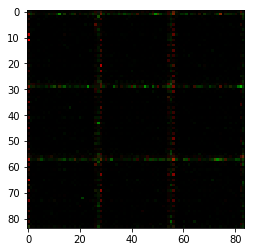

Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 3.8069
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 3.3743
Epoch 1/1... Discriminator Loss: 2.7557... Generator Loss: 8.2402
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.0720
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 2.7310
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 3.5803
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 3.2270
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 3.3073
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 2.3095
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 3.4090


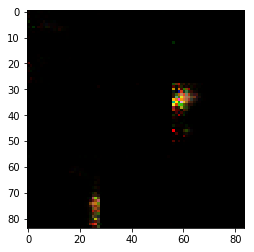

Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 4.0412
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.6434
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.7406
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 2.9424
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 3.4691
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.9890
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 2.0812
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 3.4170
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.6755


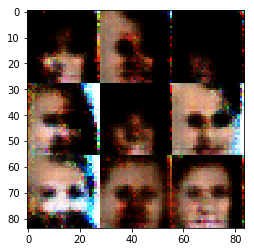

Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 2.9288
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 3.3808
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 3.2003
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 3.4256
Epoch 1/1... Discriminator Loss: 1.9354... Generator Loss: 5.5776
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.8293
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.0117
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.7470
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 2.3314


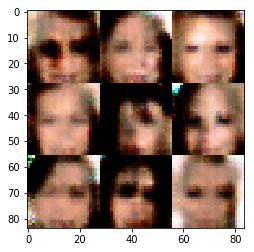

Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.8292
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.0200
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.0394
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 2.4975
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 3.5687
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.9291


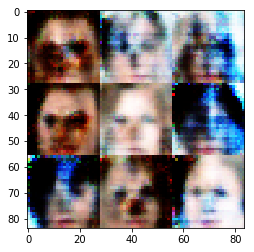

Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 2.9094
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 2.0686
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.9670
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 2.5844
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.4034


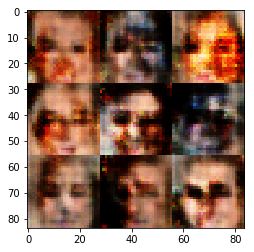

Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.6459
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.5907
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.8529
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.9991
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.2162


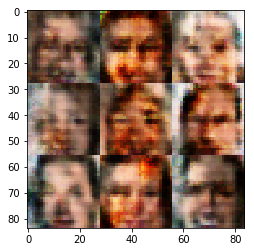

Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.3778
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.4333
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 1.3214


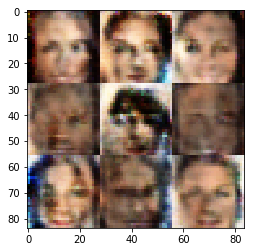

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 2.2481
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.7444
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.5365


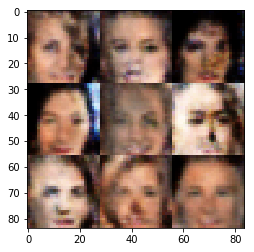

Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.4355
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.5575
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.3446


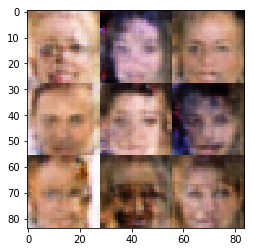

Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.1423


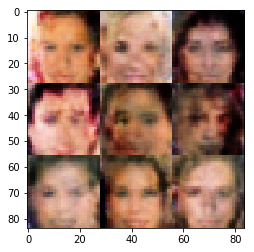

Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.3813
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.4323


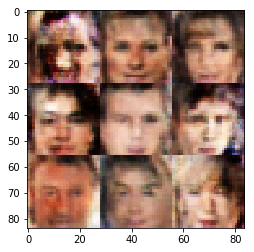

Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8842


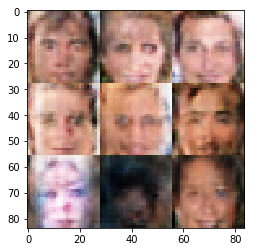

Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.1134


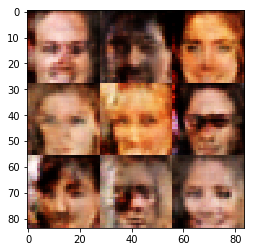

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.0686


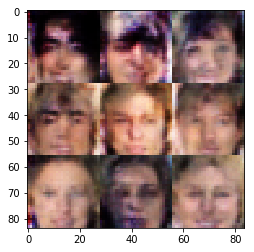

Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.9005


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)